# Histogram of Oriented Gradients (HOG) #
<font color = "orange">_Sudarsanan A K <BR>
    SC21M063_</font>

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt 
import skimage.feature as skim

In [2]:
def get_differential_filter():
    # 3 x 3 Sobel filter
    filter_x = np.array([[1,0,-1],[2,0,-2],[1,0,-1]])
    filter_y = np.array([[1,2,1],[0,0,0],[-1,-2,-1]])
    return filter_x, filter_y

In [3]:
def filter_image(im, filter):
    im_filtered = np.zeros_like(im)
    filter_flattened = filter.flatten()
    height = len(im)
    width = len(im[0])
    im_padded = np.pad(im,1)

    for i in range(height):
        for j in range(width):
            im_window = im_padded[i:i+3,j:j+3].flatten()
            im_filtered[i][j] = np.dot(im_window, filter_flattened)

    return im_filtered

In [4]:
def get_gradient(im_dx, im_dy):
    height = len(im_dx)
    width = len(im_dy[0])
    grad_mag = np.zeros_like(im_dx,dtype=float)
    grad_angle = np.zeros_like(im_dx,dtype=float)
    for i in range(height):
        grad_mag[i] = [np.linalg.norm([dX,dY]) for (dX,dY) in zip(im_dx[i],im_dy[i])]
        for j in range(width):
            dX = im_dx[i][j]
            dY = im_dy[i][j]
            if abs(dX) > 0.00001:
                grad_angle[i][j] = np.arctan(float(dY/dX)) + (np.pi/2)
            else:
                if dY < 0 and dX < 0:
                    grad_angle[i][j] = 0
                else:
                    grad_angle[i][j] = np.pi
    return grad_mag, grad_angle

In [5]:
def build_histogram(grad_mag, grad_angle, cell_size):
    height = len(grad_mag)
    width = len(grad_mag[0])
    nBins = 6
    x_corner = 0
    y_corner = 0
    ori_histo = np.zeros((int(height / cell_size), int(width / cell_size), nBins), dtype=float)
    while (x_corner + cell_size) <= height:
        while (y_corner + cell_size) <= width:
            hist = np.zeros((6), dtype=float)
            magROI = grad_mag[x_corner:x_corner+cell_size, y_corner:y_corner+cell_size].flatten()
            angleROI = grad_angle[x_corner:x_corner+cell_size, y_corner:y_corner+cell_size].flatten()
            for i in range(cell_size*cell_size):
                angleInDeg = angleROI[i] * (180 / np.pi)
                if angleInDeg >=0 and angleInDeg < 30:
                    hist[0] += magROI[i]
                elif angleInDeg >=30 and angleInDeg < 60:
                    hist[1] += magROI[i]
                elif angleInDeg >=60 and angleInDeg < 90:
                    hist[2] += magROI[i]
                elif angleInDeg >=90 and angleInDeg < 120:
                    hist[3] += magROI[i]
                elif angleInDeg >=120 and angleInDeg < 150:
                    hist[4] += magROI[i]
                else:
                    hist[5] += magROI[i]
            ori_histo[int(x_corner/cell_size),int(y_corner/cell_size),:] = hist
            y_corner += cell_size
        x_corner += cell_size
        y_corner = 0
    return ori_histo

In [6]:
def get_block_descriptor(ori_histo, block_size):
    x_window = 0
    y_window = 0
    height = len(ori_histo)
    width = len(ori_histo[0])
    ori_histo_normalized = np.zeros(((height-(block_size-1)), (width-(block_size-1)), (6*(block_size**2))), dtype=float)
    while x_window + block_size <= height:
        while y_window + block_size <= width:
            concatednatedHist = ori_histo[x_window:x_window + block_size, y_window:y_window + block_size,:].flatten()
            histNorm = np.sqrt(np.sum(np.square(concatednatedHist)) + 0.001)
            ori_histo_normalized[x_window,y_window,:] = [(h_i / histNorm) for h_i in concatednatedHist]
            y_window += block_size
        x_window += block_size
        y_window = 0
    return ori_histo_normalized

In [7]:
def extract_hog(im):
    # convert grey-scale image to double format
    im = im.astype('float') / 255.0
    # Normalize image to [0,1]
    im = (im - np.min(im)) / np.max(im)
    x_filter, y_filter = get_differential_filter()
    dx = filter_image(im, x_filter)
    dy = filter_image(im, y_filter)
    mag_matrix, angle_mat = get_gradient(dx, dy)
    histogramMat = build_histogram(mag_matrix, angle_mat, 8)
    hog_descriptors = get_block_descriptor(histogramMat, 2)
    hog = hog_descriptors.flatten()
    # VISUALIZATION CODE FOR HOG. UNCOMMENT IF NEEDED
    # visualize_hog(im, hog, 8, 2)
    return hog

In [8]:
def visualize_hog(im, hog, cell_size, block_size):
    num_bins = 6
    max_len = 7  # control sum of segment lengths for visualized histogram bin of each block
    im_h, im_w = im.shape
    num_cell_h, num_cell_w = int(im_h / cell_size), int(im_w / cell_size)
    num_blocks_h, num_blocks_w = num_cell_h - block_size + 1, num_cell_w - block_size + 1
    histo_normalized = hog.reshape((num_blocks_h, num_blocks_w, block_size**2, num_bins))
    histo_normalized_vis = np.sum(histo_normalized**2, axis=2) * max_len  # num_blocks_h x num_blocks_w x num_bins
    angles = np.arange(0, np.pi, np.pi/num_bins)
    mesh_x, mesh_y = np.meshgrid(np.r_[cell_size: cell_size*num_cell_w: cell_size], np.r_[cell_size: cell_size*num_cell_h: cell_size])
    mesh_u = histo_normalized_vis * np.sin(angles).reshape((1, 1, num_bins))  # expand to same dims as histo_normalized
    mesh_v = histo_normalized_vis * -np.cos(angles).reshape((1, 1, num_bins))  # expand to same dims as histo_normalized
    plt.imshow(im, cmap='gray', vmin=0, vmax=1)
    for i in range(num_bins):
        plt.quiver(mesh_x - 0.5 * mesh_u[:, :, i], mesh_y - 0.5 * mesh_v[:, :, i], mesh_u[:, :, i], mesh_v[:, :, i],
                   color='white', headaxislength=0, headlength=0, scale_units='xy', scale=1, width=0.002, angles='xy')
    plt.show()

In [9]:
def box_iou(box1,box2, boxSize):
    # boxes have same area - boxSize ** 2 in our case
    sumOfAreas = 2*(boxSize**2)
    #        col min  row min  col max           row max
    box_1 = [box1[0], box1[1], box1[0] + boxSize, box1[1] + boxSize]
    box_2 = [box2[0], box2[1], box2[0] + boxSize, box2[1] + boxSize]
    intersectionArea = (min(box_1[2],box_2[2]) - max(box_1[0], box_2[0])) * (min(box_1[3],box_2[3]) - max(box_1[1], box_2[1]))
    return float(intersectionArea / (sumOfAreas - intersectionArea))

In [10]:
def face_recognition(I_target, I_template):
    template_HOG = extract_hog(I_template)
    template_HOG = template_HOG - np.mean(template_HOG) # Normalize
    template_HOG_norm = np.linalg.norm(template_HOG)
    img_h, img_w = I_target.shape
    box_h, box_w = I_template.shape
    x = 0
    y = 0
    ## FIND ALL BOUNDING BOXES ##
    all_bounding_boxes = []
    while x + box_h <= img_h:
        print("Searching in row", x)
        while y + box_w <= img_w:
            img_window = I_target[x:x+box_h, y:y+box_w]
            img_HOG = extract_hog(img_window)
            img_HOG = img_HOG - np.mean(img_HOG) # Normalize
            img_HOG_norm = np.linalg.norm(img_HOG)
            score = float(np.dot(template_HOG, img_HOG) / (template_HOG_norm*img_HOG_norm))
            all_bounding_boxes.append([y,x,score])
            y += 3 # A stride of 3 is enough to produce a good result for the target. Change as needed
        x += 3
        y = 0
    print("Search complete. Computing scores.")
    # Sort by score
    bounding_boxes = []
    all_bounding_boxes = sorted(list(all_bounding_boxes),key=lambda box: box[2], reverse=True)

    ## THRESHOLDING ##
    thresholded_boxes = []
    for box in all_bounding_boxes:
        if box[2] >= 0.6: # Thresholding
            thresholded_boxes.append(box)
    print("Number of boxes after thresholding: ", len(thresholded_boxes))
    ## NON MAXIMUM SUPPRESSION ##
    while thresholded_boxes != []:
        currBox = thresholded_boxes[0]
        bounding_boxes.append(currBox)
        toRemove = []
        for box in thresholded_boxes:
            if box_iou(currBox, box, box_w) >= 0.5:
                toRemove.append(box)
        for remBox in toRemove:
            thresholded_boxes.remove(remBox)
    return np.array(bounding_boxes)

In [11]:
def visualize_face_detection(I_target,bounding_boxes,box_size):

    hh,ww,cc=I_target.shape

    fimg=I_target.copy()
    for ii in range(bounding_boxes.shape[0]):

        x1 = bounding_boxes[ii,0]
        x2 = bounding_boxes[ii, 0] + box_size 
        y1 = bounding_boxes[ii, 1]
        y2 = bounding_boxes[ii, 1] + box_size

        if x1<0:
            x1=0
        if x1>ww-1:
            x1=ww-1
        if x2<0:
            x2=0
        if x2>ww-1:
            x2=ww-1
        if y1<0:
            y1=0
        if y1>hh-1:
            y1=hh-1
        if y2<0:
            y2=0
        if y2>hh-1:
            y2=hh-1

        fimg = cv2.rectangle(fimg, (int(x1),int(y1)), (int(x2),int(y2)), (255, 0, 0), 1)
        cv2.putText(fimg, "%.2f"%bounding_boxes[ii,2], (int(x1)+1, int(y1)+2), cv2.FONT_HERSHEY_SIMPLEX , 0.5, (0, 255, 0), 2, cv2.LINE_AA)

    plt.figure(3)
    plt.imshow(fimg, vmin=0, vmax=1)
    plt.savefig('output_HOG_face_detection.png')

Searching in row 0
Searching in row 3
Searching in row 6
Searching in row 9
Searching in row 12
Searching in row 15
Searching in row 18
Searching in row 21
Searching in row 24
Searching in row 27
Searching in row 30
Searching in row 33
Searching in row 36
Searching in row 39
Searching in row 42
Searching in row 45
Searching in row 48
Searching in row 51
Searching in row 54
Searching in row 57
Searching in row 60
Searching in row 63
Searching in row 66
Searching in row 69
Searching in row 72
Searching in row 75
Searching in row 78
Searching in row 81
Searching in row 84
Search complete. Computing scores.
Number of boxes after thresholding:  60


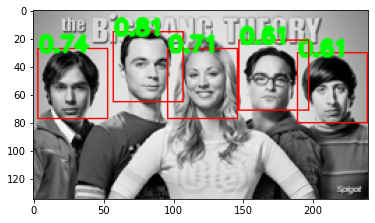

In [17]:
if __name__=='__main__':

    # Sample image to test intermediate output.
    # im = cv2.imread('Einstein.jpg', 0)
    # hog = extract_hog(im)
    
    I_target= cv2.imread('data/target.png', 0)
    #MxN image

    I_template = cv2.imread('data/template.png', 0)
    #mxn  face template

    bounding_boxes=face_recognition(I_target, I_template)

    I_target_c= cv2.imread('data/target.png')
    # MxN image (just for visualization)
    visualize_face_detection(I_target_c, bounding_boxes, I_template.shape[0])
    #this is visualization code.